<p align="center">
  <img src="https://upload.wikimedia.org/wikipedia/commons/7/78/Eindhoven_University_of_Technology_logo_new.png?20231008195526" alt="TU/e Logo" width="200px"/>
</p>

# Assignment 1: Evolutionary Process Discovery

**Course:** 1BM120 – Decision Making with Artificial Intelligence  
**Date:** *Q4 - 2025*  

---

## Group 3

- **Sadra Moosavi Lar**  
  ✉️ [s.s.moosavi.lar@student.tue.nl](mailto:s.s.moosavi.lar@student.tue.nl)

- **Floris van Hasselt**  
  ✉️ [f.j.p.v.hasselt@student.tue.nl](mailto:f.j.p.v.hasselt@student.tue.nl)

- **Sam Fiers**  
  ✉️ [s.s.w.fiers@student.tue.nl](mailto:s.s.w.fiers@student.tue.nl)

---

**Repository:** [GitHub – Group 3 Repo](https://github.com/sadra-hub/1BM120-decisiondecisionMakingWithAI)

---

## Description

This assignment focuses on discovering a **Petri Net (PN) matrix** from logged activity traces recorded by a company. The data is provided in `dataset_a1.txt`, and the objective is to extract a meaningful process model using **evolutionary algorithms** and evaluate its performance based on alignment and fitness.

In [36]:
import random
import time
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from deap import base, creator, tools, algorithms
import seaborn as sns
from fitness_module import fitness, sol_to_graphviz

/Users/sadra/miniconda3/envs/1BM120/lib/python3.13/site-packages/deap/creator.py:185: RuntimeWarning: A class named 'FitnessMax' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "
/Users/sadra/miniconda3/envs/1BM120/lib/python3.13/site-packages/deap/creator.py:185: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "


gen	nevals	max                               	avg     
0  	100   	(np.float64(-3.7665099622599625),)	-9.64873
1  	74    	(np.float64(-2.653242923742924),) 	-7.38965
2  	68    	(np.float64(-2.527680014430014),) 	-5.81434
3  	69    	(np.float64(-0.8176956654456655),)	-4.95455
4  	67    	(np.float64(-0.703242923742924),) 	-3.92684
5  	72    	(np.float64(0.2652795815295815),) 	-2.92812
6  	74    	(np.float64(0.2634237429237427),) 	-2.58336
7  	77    	(np.float64(0.3874675324675321),) 	-2.35113
8  	71    	(np.float64(0.4384870129870128),) 	-1.76369
9  	72    	(np.float64(0.4586151626151624),) 	-1.3608 
10 	67    	(np.float64(0.49810822510822494),)	-0.952373
11 	71    	(np.float64(0.49810822510822494),)	-0.596543
12 	66    	(np.float64(0.49810822510822494),)	-0.83551 
13 	77    	(np.float64(0.5337626262626258),) 	-0.688904
14 	77    	(np.float64(0.5585836940836938),) 	-0.460922
15 	72    	(np.float64(0.6662723942723939),) 	-0.314243
16 	62    	(np.float64(0.6599527417027423),) 	-0.332868
17 

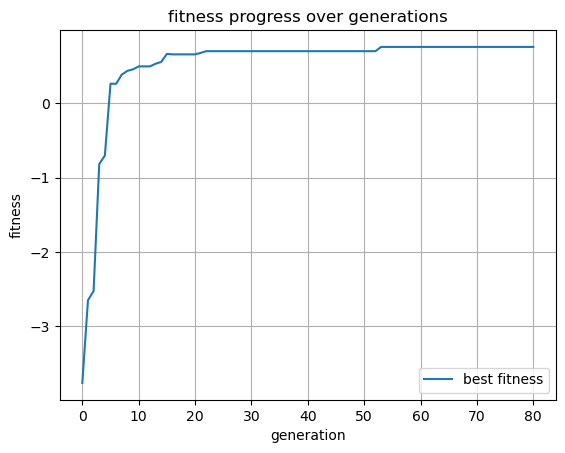

In [37]:
# EXERCISE 1: Genetic Algorithm with DEAP

# constants
N_VARS = 24
MIN_VAL = 0
MAX_VAL = 8
POP_SIZE = 100
N_GEN = 80
CXPB = 0.6
MUTPB = 0.3

# define deap framework (1.0,) means maximization
creator.create("FitnessMax", base.Fitness, weights=(1.0,))
creator.create("Individual", list, fitness=creator.FitnessMax)

toolbox = base.Toolbox()

toolbox.register("attr_int", random.randint, MIN_VAL, MAX_VAL)
toolbox.register("individual", tools.initRepeat, creator.Individual, toolbox.attr_int, N_VARS)
toolbox.register("population", tools.initRepeat, list, toolbox.individual)

toolbox.register("evaluate", fitness)
toolbox.register("mate", tools.cxTwoPoint)
toolbox.register("mutate", tools.mutUniformInt, low=MIN_VAL, up=MAX_VAL, indpb=0.2)
toolbox.register("select", tools.selTournament, tournsize=3)

# initialize population and hall of fame
pop = toolbox.population(n=POP_SIZE)
hof = tools.HallOfFame(1)


stats = tools.Statistics(lambda ind: ind.fitness.values)
stats.register("max", max)
stats.register("avg", lambda fits: sum(f[0] for f in fits) / len(fits))

pop, logbook = algorithms.eaSimple(
    pop, toolbox,
    cxpb=CXPB, mutpb=MUTPB,
    ngen=N_GEN,
    stats=stats, halloffame=hof,
    verbose=True
)

# plot results
plt.plot(logbook.select("gen"), logbook.select("max"), label="best fitness")
plt.xlabel("generation")
plt.ylabel("fitness")
plt.title("fitness progress over generations")
plt.grid(True)
plt.legend()
plt.show()

In [38]:
print("Best solution:", hof[0])
print("Best fitness:", hof[0].fitness.values[0])

Best solution: [7, 5, 7, 8, 0, 2, 2, 3, 3, 7, 0, 4, 5, 7, 3, 6, 1, 3, 7, 8, 5, 8, 7, 8]
Best fitness: 0.7604725552225553


Exercise 1 solutions 
Best solution: [3, 8, 3, 1, 0, 1, 1, 8, 1, 3, 3, 5, 2, 5, 3, 6, 5, 7, 1, 5, 2, 5, 7, 8]
Best fitness: 0.7026320346320347

In [ ]:
# EXERCISE 2: this function is used to run the genetic algorithm with different
# crossover, mutation and selection methods

def run_ga(crossover, mutation, selection, label):
    toolbox.unregister("mate")
    toolbox.unregister("mutate")
    toolbox.unregister("select")

    toolbox.register("mate", crossover)
    toolbox.register("mutate", mutation, indpb=0.2)

    if selection == tools.selTournament:
        toolbox.register("select", selection, tournsize=3)
    else:
        toolbox.register("select", selection)

    pop = toolbox.population(n=POP_SIZE)
    hof = tools.HallOfFame(1)

    stats = tools.Statistics(lambda ind: ind.fitness.values)
    stats.register("max", max)
    stats.register("avg", lambda fits: sum(f[0] for f in fits) / len(fits))

    start_time = time.time()
    pop, log = algorithms.eaSimple(
        pop, toolbox, cxpb=CXPB, mutpb=MUTPB,
        ngen=N_GEN, stats=stats, halloffame=hof, verbose=False
    )
    end_time = time.time()

    abf = max(log.select("avg"))
    duration = end_time - start_time

    # to get the best fitness of the final best solution
    best_fitness = hof[0].fitness.values[0] if hof and hof[0].fitness.valid else float('nan')

    print(f"{label} - ABF: {abf:.2f}, Best Fitness: {best_fitness:.2f}, Time: {duration:.2f}s")
    return abf, duration, log, best_fitness

In [40]:
## Different crossover, mutation and selection methods for Exercise 2
# Crossover operators
crossovers = {
    "cxTwoPoint": tools.cxTwoPoint,
    "cxOrdered": tools.cxOrdered,
}

# Mutation operators
mutations = {
    "mutFlipBit": tools.mutFlipBit,
    "mutShuffleIndexes": tools.mutShuffleIndexes,
}

# Selection operators
selections = {
    "selTournament": tools.selTournament,
    "selRoulette": tools.selRoulette,
}

# Adding some short name to make the legend more readable
short_names = {
    "cxTwoPoint": "2P",
    "cxOrdered": "Ord",
    "mutFlipBit": "FB",
    "mutShuffleIndexes": "SI",
    "selTournament": "Tour",
    "selRoulette": "Rou"
}


2P-FB-Tour - ABF: -0.49, Best Fitness: 0.53, Time: 150.32s
2P-FB-Tour - ABF: -0.44, Best Fitness: 0.55, Time: 115.82s
2P-FB-Tour - ABF: -0.23, Best Fitness: 0.59, Time: 119.98s
2P-FB-Tour - ABF: -0.36, Best Fitness: 0.67, Time: 108.31s
2P-FB-Tour - ABF: -0.45, Best Fitness: 0.51, Time: 111.05s
2P-FB-Tour - ABF: -0.57, Best Fitness: 0.59, Time: 179.03s
2P-FB-Tour - ABF: -0.20, Best Fitness: 0.60, Time: 124.22s
2P-FB-Tour - ABF: -0.40, Best Fitness: 0.53, Time: 114.85s
2P-FB-Tour - ABF: -0.32, Best Fitness: 0.52, Time: 116.95s
2P-FB-Tour - ABF: -0.44, Best Fitness: 0.60, Time: 117.91s
2P-FB-Rou - ABF: -0.37, Best Fitness: 0.54, Time: 127.17s
2P-FB-Rou - ABF: -0.50, Best Fitness: 0.30, Time: 92.01s
2P-FB-Rou - ABF: -0.42, Best Fitness: 0.47, Time: 121.46s
2P-FB-Rou - ABF: -0.67, Best Fitness: 0.35, Time: 94.47s
2P-FB-Rou - ABF: -0.92, Best Fitness: 0.29, Time: 92.59s
2P-FB-Rou - ABF: -0.50, Best Fitness: 0.37, Time: 121.74s
2P-FB-Rou - ABF: -0.47, Best Fitness: 0.50, Time: 108.97s
2P-FB-R

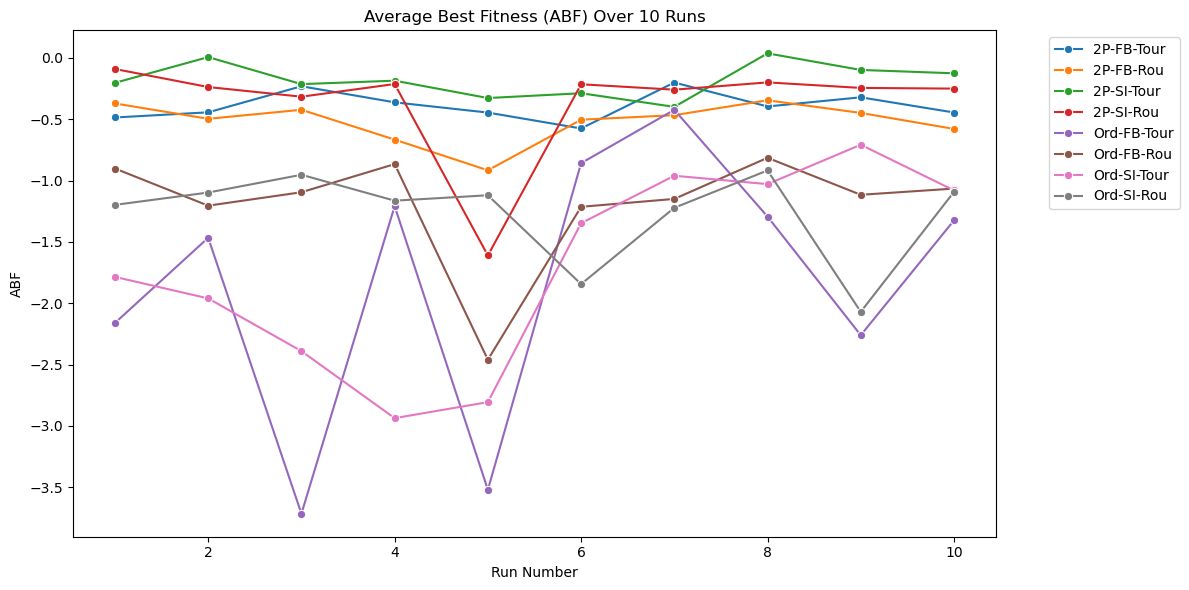

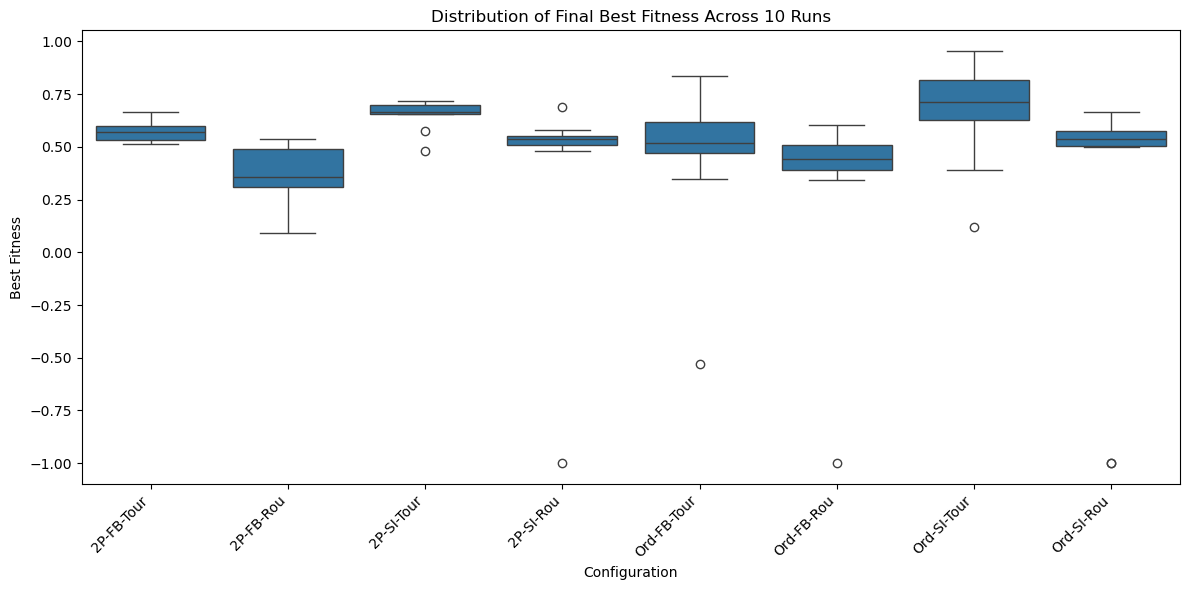

                  ABF  Time (Seconds)
Config                               
2P-SI-Tour  -0.179205      112.874971
2P-SI-Rou   -0.363156       97.271730
2P-FB-Tour  -0.390168      125.844132
2P-FB-Rou   -0.521194      105.223790
Ord-FB-Rou  -1.188152      122.246342
Ord-SI-Rou  -1.267255       71.293133
Ord-SI-Tour -1.699877      475.104350
Ord-FB-Tour -1.822699       93.663425


In [ ]:
results = []

# running each configuration 10 times
for cx_name, cx in crossovers.items():
    for mut_name, mut in mutations.items():
        for sel_name, sel in selections.items():
            label = f"{short_names[cx_name]}-{short_names[mut_name]}-{short_names[sel_name]}"
            for run in range(10):
                abf, time_taken, log, best_fitness = run_ga(cx, mut, sel, label)
                results.append({
                    "Crossover": cx_name,
                    "Mutation": mut_name,
                    "Selection": sel_name,
                    "ABF": abf,
                    "Best Fitness": best_fitness,
                    "Time (Seconds)": time_taken,
                    "Run": run + 1,
                    "Config": label
                })

df = pd.DataFrame(results)

# --- Line Plot: ABF over 10 runs ---
plt.figure(figsize=(12, 6))
sns.lineplot(data=df, x="Run", y="ABF", hue="Config", marker="o")
plt.title("Average Best Fitness (ABF) Over 10 Runs")
plt.ylabel("ABF")
plt.xlabel("Run Number")
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

# --- Boxplot: Distribution of Best Fitness Values ---
plt.figure(figsize=(12, 6))
sns.boxplot(data=df, x="Config", y="Best Fitness")
plt.xticks(rotation=45, ha='right')
plt.title("Distribution of Final Best Fitness Across 10 Runs")
plt.ylabel("Best Fitness")
plt.xlabel("Configuration")
plt.tight_layout()
plt.show()


summary = df.groupby("Config")[["ABF", "Time (Seconds)"]].mean().sort_values(by=["ABF"], ascending=False)
print(summary)

In [42]:
## Exercise 3

## Different mutation and crossover probabilities for Exercise 3
# mutation probabilities
mutation_probs = [0.2,0.4,0.6,0.8]

# crossover probabilities
crossover_probs = [0.2,0.4,0.6,0.8]

In [43]:
results = []

# Best configuration
crossover = tools.cxTwoPoint
mutation = tools.mutFlipBit
selection = tools.selTournament
label = "2P-FB-Tour"

for cxpb in crossover_probs:
    for mutpb in mutation_probs:
        # here we're running this 10 times for each probability
        for run in range(10):
            
            CXPB = cxpb
            MUTPB = mutpb
            
            abf, time_taken, log, best_fitness = run_ga(crossover, mutation, selection, label)
            
            results.append({
                "Crossover Prob": cxpb,
                "Mutation Prob": mutpb,
                "ABF": abf,
                "Best Fitness": best_fitness,
                "Time (Seconds)": time_taken,
                "Run": run + 1
            })

df = pd.DataFrame(results)

# Compute average best fitness per combination
summary = df.groupby(["Crossover Prob", "Mutation Prob"])["Best Fitness"].mean()

# Find best config (highest best fitness)

best_combo = summary.idxmax()
best_fitness = summary.max()

BEST_CXPB = best_combo[0]
BEST_MUTPB = best_combo[1]

print(f"✅ Best combo: CX={best_combo[0]}, MUT={best_combo[1]} with mean Best Fitness = {best_fitness:.4f}")

2P-FB-Tour - ABF: -0.37, Best Fitness: 0.31, Time: 51.37s
2P-FB-Tour - ABF: -0.03, Best Fitness: 0.49, Time: 75.42s
2P-FB-Tour - ABF: -0.32, Best Fitness: 0.33, Time: 53.69s
2P-FB-Tour - ABF: -0.07, Best Fitness: 0.51, Time: 60.32s
2P-FB-Tour - ABF: -0.18, Best Fitness: 0.32, Time: 71.37s
2P-FB-Tour - ABF: -0.23, Best Fitness: 0.39, Time: 64.76s
2P-FB-Tour - ABF: -0.22, Best Fitness: 0.39, Time: 61.07s
2P-FB-Tour - ABF: -0.06, Best Fitness: 0.39, Time: 51.74s
2P-FB-Tour - ABF: -0.04, Best Fitness: 0.49, Time: 57.53s
2P-FB-Tour - ABF: -0.10, Best Fitness: 0.53, Time: 70.06s
2P-FB-Tour - ABF: -1.14, Best Fitness: 0.54, Time: 67.67s
2P-FB-Tour - ABF: -1.15, Best Fitness: 0.51, Time: 86.88s
2P-FB-Tour - ABF: -0.97, Best Fitness: 0.51, Time: 96.69s
2P-FB-Tour - ABF: -1.22, Best Fitness: 0.35, Time: 100.11s
2P-FB-Tour - ABF: -1.07, Best Fitness: 0.47, Time: 98.76s
2P-FB-Tour - ABF: -1.05, Best Fitness: 0.63, Time: 80.12s
2P-FB-Tour - ABF: -1.18, Best Fitness: 0.54, Time: 58.39s
2P-FB-Tour - 

In [44]:
# Exercise 4 : Tool decorator

def repair_candidate(matrix):
    repaired = matrix.copy()

    # using step size of 2 to iterate over [src, tgt] pairs
    for i in range(0, len(repaired), 2):
        src = repaired[i]
        tgt = repaired[i + 1]

        # Fix self-loops
        while src == tgt:
            tgt = np.random.randint(0, MAX_VAL + 1) # using MAX_VAL + 1 to include MAX_VAL

        # Fix backwards visible transitions (only for visible transitions: i >= 4)
        # i = 0 → t0, i = 2 → t1, i = 4 → t2 (visible starts at transition index 2)
        if i >= 4 and src > tgt:
            tgt = np.random.randint(src, MAX_VAL + 1)

        # Write back into flat array
        repaired[i] = src
        repaired[i + 1] = tgt

    return repaired


def repair_decorator(operator):
    def wrapper(*args, **kwargs):
        offspring = operator(*args, **kwargs)
        for child in offspring:
            repaired_matrix = repair_candidate(np.array(child))
            child[:] = repaired_matrix.tolist()  # overwrite with repaired values
        return offspring
    return wrapper

## Exercise 5

In [49]:
# exercise 5: decorator usage

# here assuming best operators are cxTwoPoint, mutFlipBit and selTournament
# change the operators accroding to the result of exercise 3

# Run 1: Without decorator
toolbox.register("mate", tools.cxTwoPoint)  # 2P
toolbox.register("mutate", tools.mutShuffleIndexes, indpb=0.2)  # SI
toolbox.register("select", tools.selTournament, tournsize=3)  # Tour

hof_before = tools.HallOfFame(1)
pop1 = toolbox.population(n=POP_SIZE*2)

pop1, log1 = algorithms.eaSimple(
    pop1, toolbox, cxpb=BEST_CXPB, mutpb=BEST_MUTPB, ngen=N_GEN*3,
    stats=stats, halloffame=hof_before, verbose=True
)

# Run 2: With decorator
toolbox.unregister("mate")
toolbox.unregister("mutate")
# we don't need to unregister select because we are not producing new individuals
# we are just selecting.

toolbox.register("mate", repair_decorator(tools.cxTwoPoint))
toolbox.register("mutate", repair_decorator(tools.mutShuffleIndexes), indpb=0.2)

hof_after = tools.HallOfFame(1)
pop2 = toolbox.population(n=POP_SIZE*2)

pop2, log2 = algorithms.eaSimple(
    pop2, toolbox, cxpb=BEST_CXPB, mutpb=BEST_MUTPB, ngen=N_GEN*3,
    stats=stats, halloffame=hof_after, verbose=True
)

# Best before decoration
sol_to_graphviz(hof_before[0], output_file="best_before.pdf")

# Best after decoration
sol_to_graphviz(hof_after[0], output_file="best_after.pdf")

gen	nevals	max                               	avg     
0  	200   	(np.float64(-2.9100841935841935),)	-9.61249
1  	182   	(np.float64(-2.702910533910534),) 	-7.43577
2  	180   	(np.float64(-0.9745),)            	-6.29389
3  	170   	(np.float64(-0.6068719058719059),)	-5.20963
4  	179   	(np.float64(-0.5541517371517373),)	-4.40516
5  	173   	(np.float64(0.28625357975357957),)	-4.11141
6  	170   	(np.float64(0.35357034632034634),)	-3.23396
7  	169   	(np.float64(0.5004292929292926),) 	-2.99559
8  	174   	(np.float64(0.5369696969696969),) 	-2.32519
9  	185   	(np.float64(0.5536363636363635),) 	-2.50591
10 	173   	(np.float64(0.5536363636363635),) 	-2.02718
11 	167   	(np.float64(0.5536363636363635),) 	-1.84806
12 	178   	(np.float64(0.5536363636363635),) 	-1.58833
13 	173   	(np.float64(0.5536363636363635),) 	-1.90511
14 	161   	(np.float64(0.5536363636363635),) 	-1.45707
15 	174   	(np.float64(0.6226172438672442),) 	-1.76457
16 	181   	(np.float64(0.6226172438672442),) 	-1.84707
17 	170   